# Data exploitation for bacteria colony simulation

Using data from real experimentations to calculate the parameters of our simulations.

Bacteria : 
- Coli
- Pseudomonas

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 1. Data Preprocessing

### 1. Presentation

The dataset is composed of various informations about the evolutions of bacterias (Coli and Pseudomonas) during a simulation. 

The features that interest us are :
- **cname** : the name of a bacteria
- **frame** : the frame during wich the bacteria was observed.
- **time** : the time of the observation
- **cellno** : the number of the cell on the current frame
- **schnitzno** : the "id" of a bacterium
- **birth** : the birth date
- **lifespan** : lifetime of a bacterium before division
- **area** : area of the bacterium
- **lentgh** :
- **angle**:
- **grate** : growth rate of the bacterium
- **width** 

### 2. Cleaning the data

As we need to clean all the files, we need to create a function to clean every dataframe.

- Deleting the useless spaces in the columns names.
- Deleting the useless columns

In [2]:
pd.options.mode.chained_assignment = None

def remove_space(x):
    return x.replace(" ","")

def cleaning(df:pd.DataFrame):
    """Return a cleaned dataframe"""
    # Cleaning the columns name : deleting the spaces
    df.columns = df.columns.str.replace(" ","")

    # Keeping important features
    features = ["cname","frame","time","cellno","schnitzno","birth","lifespan","length","area","angle","grate","width"]
    df = df[features]
    
    # Removing the spaces in cname
    df["cname"] = df["cname"].apply(remove_space)

    return df

def cleaning2(df):
    """Remove the problematic data"""
    # Removing the rows with cname = 0 0T 0H
    df = df.loc[df["cname"]!="0"]
    df = df.loc[df["cname"]!="0T" ]
    df = df.loc[df["cname"]!="0H"]

    # Calculating the max frame and removing the corresponding rows
    # max = df["frame"].max()
    # df = df.loc[df["frame"]!=max]

    return df

### 3. Loading all the data

In [3]:
# Uncomment the corresponding line to change of data
all_files = glob.glob("./Data_Durvernoy/coli/*.txt")
# all_files = glob.glob("./Data_Durvernoy/pseudomonas/*.txt")

# Creating the list of dataframes
Ldf = []
for f in all_files:
    Ldf.append(cleaning(pd.read_csv(f,sep="\t")))

DF = pd.concat(Ldf)
# DF

## 4. Extracting the experimental parameters

In [4]:
# Lists of parameters

Number_t_E = []     # Numbers of bacteria as a function of time
Increment_E =[]     # Increment final_length - birth length
length_E=[]         # length by time 
length_birth_E=[]   # birth length
length_div_E = []   # length at division
growth_rate_E=[]    # growth rate
Gen_E=[]            # generation
First_div_E=[]      # length at first division
Theta_E =[]         # angle
lifespan_E=[]       # lifespan
width_birth_E=[]    # width at birth

In [5]:
# Calculating the number of bacteria by time
Nb = np.zeros((len(Ldf),DF["frame"].max()))


for i in range(0,len(Ldf)):
    df = Ldf[i]
    for j in range(2,df["frame"].max()+1):
        d = df.loc[df["frame"]==j]
        # d = d.reset_index(drop="True")
        # d=d.sort_values(by='time',axis=0)
        nrow = d.shape[0]
        Nb[i,j-1]=nrow


In [6]:
# Iterating on the files
for df in Ldf:
    df = cleaning2(df)  # Deleting the inapprorpriate values from the df: cname 0 0T 0H
    # Iterating on the different bacteria (by their schnitzo number)
    for i in range(3,df["schnitzno"].max()+1):
        # Selecting the interesting data
        d = df.loc[df["schnitzno"]==i]
        d = d.reset_index(drop="True")
        d=d.sort_values(by='time',axis=0)
        nrow = d.shape[0]

        # Saving the new data
        if nrow>1 and d["frame"][nrow-1]!=df["frame"].max():    # Checking that the row is not unique or that the bacterium appears on the last frame
            Increment_E.append(d["length"][0]-d["length"][nrow-1])
            length_E.append(list(d["length"]))
            length_div_E.append(d["length"][nrow-1])
            length_birth_E.append(d["length"][0])
            if(0<=np.log(d["length"][nrow-1]/d["length"][0])/(d["time"][nrow-1]-d["time"][0])):
                growth_rate_E.append(np.log(d["length"][nrow-1]/d["length"][0])/(d["time"][nrow-1]-d["time"][0]))
            Gen_E.append(len(d["cname"][0]))
            width_birth_E.append(d["width"][0])
            lifespan_E.append(d["lifespan"][0])

            if(len(d["cname"][0])==3):
                First_div_E.append(d["length"][0]) 

# Converting the lists into arrays
gre = np.array(growth_rate_E)
incre = np.array(Increment_E)
lde = np.array(length_div_E)
lbe  = np.array(length_birth_E)
gene = np.array(Gen_E)
lpe = np.array(lifespan_E)
fde = np.array(First_div_E)
we = np.array(width_birth_E)

## 5. Calculating the parameters

In [16]:
dict = {"growth rate" : [np.mean(gre)],
        "increment" : [np.mean(incre)],
        "length at division" :[np.mean(lde)*0.1],
        "length at birth" : [np.mean(lbe)*0.1],
        "lifespan" : [np.mean(lpe)],
        "length at first division ": [np.mean(fde)*0.1],
        "initial width": [np.mean(we)*0.1]}

data = pd.DataFrame(dict)
data

,growth rate,increment,length at division,length at birth,lifespan,length at first division,initial width
0,0.028433,-55.452268,12.368696,6.82347,24.097009,6.476389,2.148584


## 6. Distributions

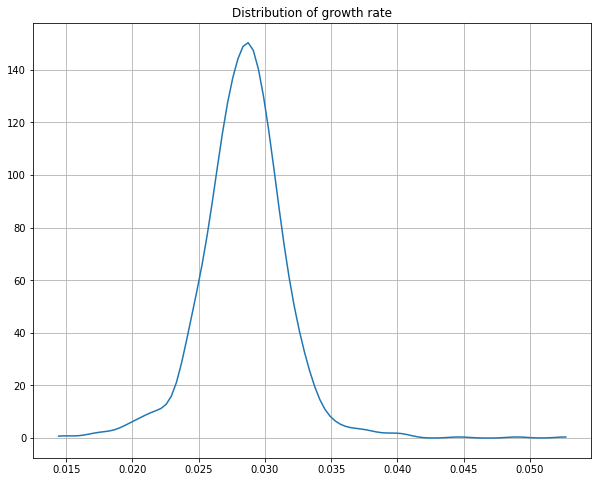

In [8]:
# Calculating the kernel density of the experimental growth rate
data = gre
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("Distribution of growth rate")
plt.grid()
plt.show()


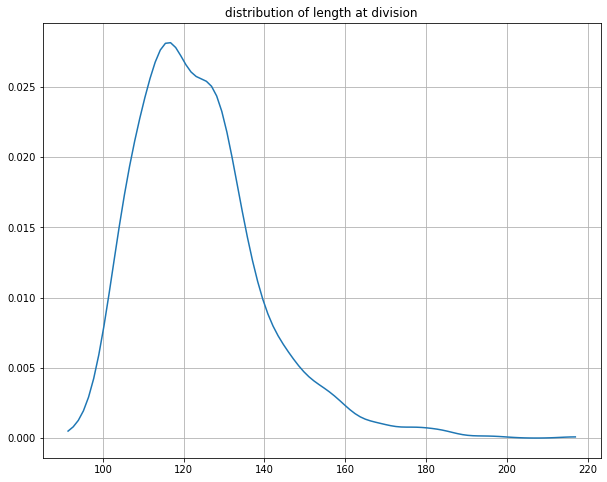

In [9]:
# Kernel density of length at division
kde = stats.gaussian_kde(lde)
x = np.linspace(lde.min(), lde.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("distribution of length at division")
plt.grid()
plt.show()

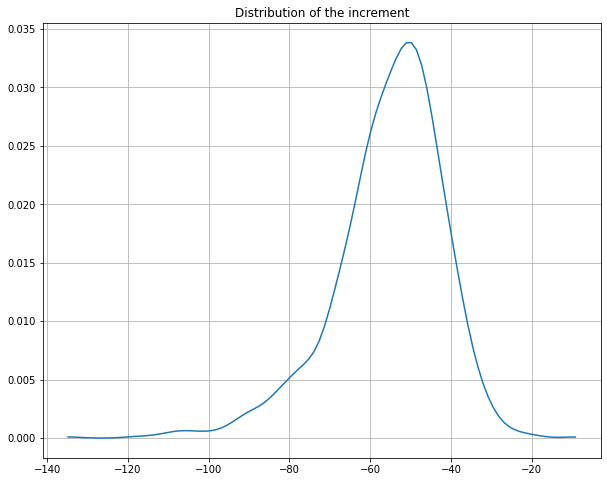

In [10]:
# Kernel density of length at increment
kde = stats.gaussian_kde(incre)
x = np.linspace(incre.min(), incre.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("Distribution of the increment")
plt.grid()
plt.show()

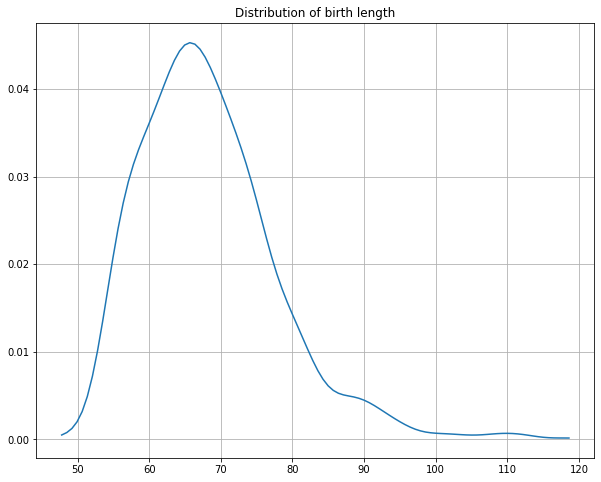

In [11]:
# Kernel density of the birth length
kde = stats.gaussian_kde(lbe)
x = np.linspace(lbe.min(), lbe.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("Distribution of birth length")
plt.grid()
plt.show()

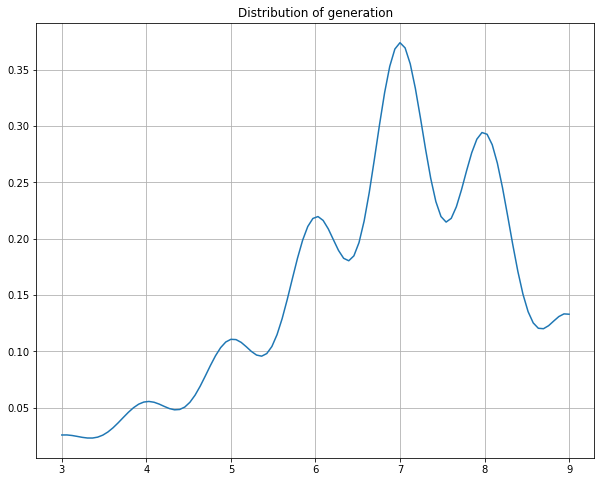

In [12]:
# Kernel density of the generation
kde = stats.gaussian_kde(gene)
x = np.linspace(gene.min(), gene.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("Distribution of generation")
plt.grid()
plt.show()

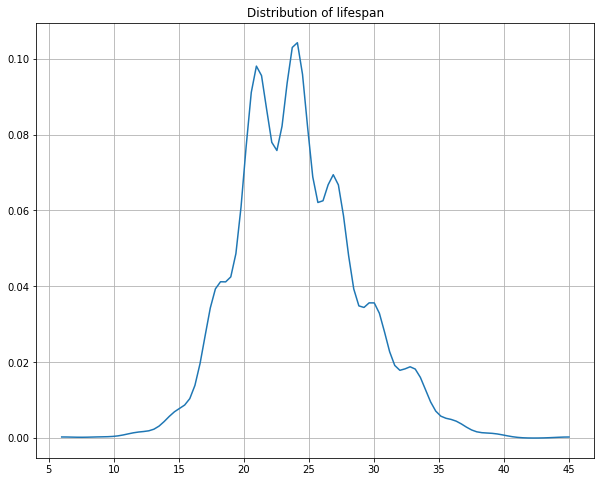

In [13]:
# Kernel density of the lifespan
kde = stats.gaussian_kde(lpe)
x = np.linspace(lpe.min(), lpe.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("Distribution of lifespan")
plt.grid()
plt.show()

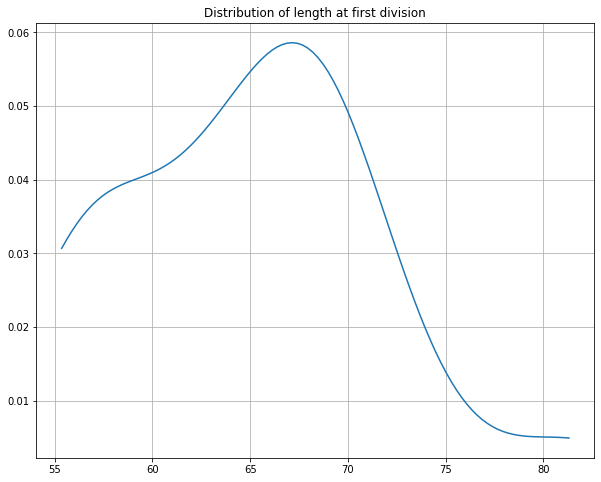

In [14]:
# Kernel density of the legth at the first division
kde = stats.gaussian_kde(fde)
x = np.linspace(fde.min(), fde.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("Distribution of length at first division")
plt.grid()
plt.show()

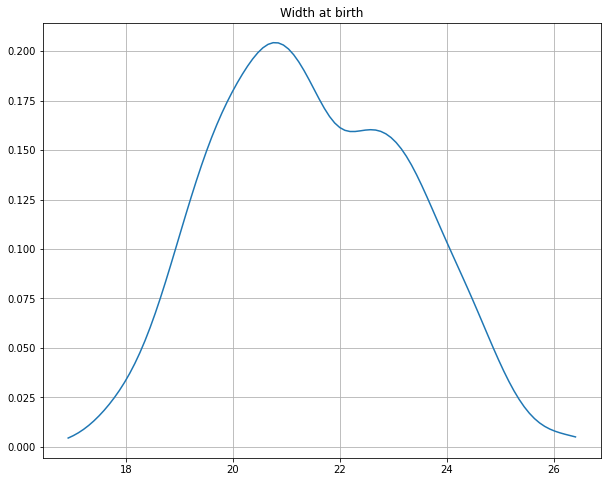

In [15]:
# Kernel density of the width at birth
kde = stats.gaussian_kde(we)
x = np.linspace(we.min(), we.max(), 100)
p = kde(x)

plt.figure(figsize=(10,8))
plt.plot(x,p)
plt.title("Width at birth")
plt.grid()
plt.show()
